In [9]:
import json
import cv2 as cv
import pickle as pkl
from typing import Dict, List
import numpy as np
import torch
from matplotlib import pyplot as plt
import os, sys
import librosa
import shutil 
import csv

from scipy import stats, spatial, ndimage
sys.path.insert(0, '/Users/evanpan/Documents/GitHub/EvansToolBox/Utils')
sys.path.insert(0, '/Users/evanpan/Documents/GitHub/Gaze_project')
sys.path.insert(0, "C:/Users/evansamaa/Documents/GitHub/EvansToolBox/Utils")
sys.path.insert(0, "C:/Users/evansamaa/Documents/GitHub/Gaze_project")
sys.path.insert(0, "C:/Users/evan1/Documents/GitHub/EvansToolBox/Utils")
sys.path.insert(0, "C:/Users/evan1/Documents/GitHub/Gaze_project")
from Signal_processing_utils import intensity_from_signal, pitch_from_signal, sparse_key_smoothing, laplacian_smoothing
from Speech_Data_util import Sentence_word_phone_parser
from prototypes.InputDataStructures import Dietic_Conversation_Gaze_Scene_Info, AgentInfo_time_varying, AgentInfo_final
from prototypes.MVP.MVP_static_saliency_list import ObjectBasedFixSaliency
from prototypes.MVP.MVP_Aversion_saliency_list import AversionSignalDrivenSaliency, CTSAversionSignalDrivenSaliency
from prototypes.MVP.MVP_look_at_point_planner import HabituationBasedPlanner, RandomPlanner, PartnerHabituationPlanner
from prototypes.MVP.MVP_eye_head_driver import HeuristicGazeMotionGenerator
from prototypes.MVP.MVP_Aversion_saliency_list import Base_Static_Saliency_List
from prototypes.EyeCatch.Saccade_model_with_internal_model import *
from prototypes.Gaze_aversion_prior.Heuristic_model import *
from prototypes.Boccignone2020.Gaze_target_planner import Scavenger_based_planner
from prototypes.Boccignone2020.Improved_gaze_target_planner import Scavenger_planner_with_nest, Scavenger_planner_simple 
from prototypes.JaliNeck.JaliNeck import NeckCurve
from prototypes.Gaze_aversion_prior.Ribhav_model import predict_aversion
from prototypes.Gaze_aversion_prior.Evan_model import Aversion111Prior, Aversion111Prior_three_party
from prototypes.InputDataStructures import AgentInfo, TurnTakingData
from prototypes.MVP.MVP_gaze_path_planner import Responsive_planner_Differnet_Targets, Responsive_planner_simple, Responsive_planner_no_heuristics, Responsive_planner_no_Gaze_deploy, Responsive_planner_React_to_gaze_no_Gaze_deploy
import pickle
import math
import re
import string
from datetime import datetime, timezone
import scipy.stats as ss
from Signal_processing_utils import interpolate1D, runEuro, pad_arrays
from scipy.interpolate import interp1d
from Geometry_Util import directions_from_rotation_angles

%load_ext autoreload
%autoreload 1

%aimport prototypes.InputDataStructures
%aimport Speech_Data_util
%aimport Signal_processing_utils
%aimport Geometry_Util
%aimport prototypes.MVP.MVP_static_saliency_list
%aimport prototypes.EyeCatch.Saccade_model_with_internal_model
%aimport prototypes.InputDataStructures
%aimport prototypes.Jin2019.EyeHeadDecomposition
%aimport prototypes.Optimization_based_head_eye_seperator.Baseline_optimization
%aimport prototypes.Boccignone2020.Improved_gaze_target_planner
%aimport prototypes.MVP.MVP_gaze_path_planner
%aimport prototypes.JaliNeck.JaliNeck
%aimport prototypes.Gaze_aversion_prior.Evan_model

def get_beats(audio, sr):
    fps = 50
    audio_energy = intensity_from_signal(audio, int(sr/fps))
    beat_ts = np.arange(0, audio_energy.shape[0]) / fps
    daudio_dt = dx_dt(audio_energy)
    Dm = 0.2
    DM = 0.7
    DM_frame = math.floor(DM / (beat_ts[1] - beat_ts[0]))
    energy_interp = interp1d(beat_ts, audio_energy, bounds_error=False)
    # iterative find audio onset between 0.2 and 0.6 seconds to identify beats
    beats = [[0, False]] # start with a pseudo beat
    for i in range(0, audio_energy.shape[0]):
        if daudio_dt[i] > 5:
            current_beat_t = beat_ts[i]
            if current_beat_t - beat_ts[beats[-1][0]] <= Dm:
                continue
            if current_beat_t - beat_ts[beats[-1][0]] >= DM:
                # these are stored as integer indexes
                start = beats[-1][0]
                end = i
                counter = start + DM_frame
                while counter < end:
                    beats.append([counter, False])
                    counter = counter + DM_frame
            beats.append([i, True])
    beats_arr = []
    for i in range(0, len(beats)):
        if beats[i][1]:
            beats_arr.append([beat_ts[beats[i][0]], audio_energy[beats[i][0]]])
    beats_arr = np.array(beats_arr)
    return beats_arr


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Pre-process Block

In [3]:
from Video_analysis_utils import get_wav_from_video 
get_wav_from_video("movie.mov", "F:/MASC/JALI_gaze/Animations/jin2019_4")

MoviePy - Writing audio in F:/MASC/JALI_gaze/Animations/jin2019_4\movie.wav


MoviePy - Done.


'F:/MASC/JALI_gaze/Animations/jin2019_4\\movie.wav'

In [5]:
speaker_id = 0
turn_taking_threshold = 2
fps = 25
np.random.seed(speaker_id)

In [14]:
# inputs (for desk top at home)
# input_folder = "/Volumes/EVAN_DISK/MASC/Ribhav_processed_dataset/"
input_folder = "F:/MASC/JALI_gaze/Animations/jin2019_4"
input_file = "movie"
outside_dataset = True
model_location = "C:/Users/evansamaa/Documents/GitHub/Gaze_project/prototypes/Gaze_aversion_prior/sentence_word_audio_velocity_model"
whisper_location = "C:/Users/evansamaa/Documents/GitHub/Gaze_project/models"
temp_folder = "F:/MASC/JALI_gaze/Animations/jin2019_4" 

In [15]:
ambient_neck_factor_0 = 0.3
jali_neck_factor_0 = 0.2
ambient_neck_factor_1 = 0.1
jali_neck_factor_1 = 0.1
ambient_neck_factor2 = 0.3
jali_neck_factor_2 = 0.2

## Get all the file paths

In [54]:

input_file_no_space = input_file.replace(" ", "_")
gaze_animation_output_location = os.path.join(*[temp_folder, "outputs"])
try:
    os.mkdir(os.path.join(*[temp_folder, "outputs"]))   
except:
    print("folder already exist")   
try:
    os.mkdir(os.path.join(*[temp_folder, "annotated_scene"]))   
except:
    print("folder already exist")    
# input_file_no_space = "'" + input_file_no_space + "'"
# for both speakers
raw_audio_path = os.path.join(*[temp_folder, input_file_no_space+".wav"]).replace(os.sep, "/")
basic_scene_data_path = "./data/look_at_points/simplest_scene2_less_items.json"
transcription_json_path = os.path.join(*[temp_folder, input_file+"_transcript.json"])
# for the first speaker
speaker_id = 0
praatoutput_path_0 = os.path.join(temp_folder, input_file_no_space+"_{}_PraatOutput.txt".format(speaker_id)).replace(os.sep, "/")
audio_path_0 = os.path.join(*[temp_folder, input_file_no_space+"_{}.wav".format(speaker_id)]).replace(os.sep, "/")
text_file_path_0 = os.path.join(*[temp_folder, input_file_no_space+"_{}.txt".format(speaker_id)]).replace(os.sep, "/")
transcript_file_path_0 = os.path.join(*[temp_folder, input_file+"_transcript.json".format(speaker_id)]).replace(os.sep, "/")
tagged_text_file_path_0 = os.path.join(*[temp_folder, input_file_no_space+"_{}_tagged.txt".format(speaker_id)]).replace(os.sep, "/")
tagged_dialog_file_path_0 = os.path.join(*[temp_folder, input_file+"_dialog_transcript_tagging_0.txt"])
if outside_dataset:
    audio_path_0 = os.path.join(*[temp_folder, input_file_no_space+"_{}.wav".format(speaker_id)]).replace(os.sep, "/")    
# output paths
output_neural_location_0 = os.path.join(*[temp_folder, "outputs", input_file+"_neural_{}.pkl".format(speaker_id)]).replace(os.sep, "/")
# other important input data (such as scene )
annotation_data_path_0= os.path.join(*[temp_folder, "annotated_scene", input_file+"_points_{}.json".format(speaker_id)]).replace(os.sep, "/")
scene_data_path_0 = os.path.join(*[temp_folder, "annotated_scene", input_file+"_scene_{}.json".format(speaker_id)]).replace(os.sep, "/")

# for the second speaker
speaker_id = 1
praatoutput_path_1 = os.path.join(temp_folder, input_file_no_space+"_{}_PraatOutput.txt".format(speaker_id)).replace(os.sep, "/")
audio_path_1 = os.path.join(*[temp_folder, input_file_no_space+"_{}.wav".format(speaker_id)]).replace(os.sep, "/")
text_file_path_1 = os.path.join(*[temp_folder, input_file_no_space+"_{}.txt".format(speaker_id)]).replace(os.sep, "/")
transcript_file_path_1 = os.path.join(*[temp_folder, input_file+"_transcript.json".format(speaker_id)]).replace(os.sep, "/")
tagged_text_file_path_1 = os.path.join(*[temp_folder, input_file_no_space+"_{}_tagged.txt".format(speaker_id)]).replace(os.sep, "/")
tagged_dialog_file_path_1 = os.path.join(*[temp_folder, input_file+"_dialog_transcript_tagging_1.txt"])
if outside_dataset:
    audio_path_1 = os.path.join(*[temp_folder, input_file_no_space+"_{}.wav".format(speaker_id)]).replace(os.sep, "/")    
# output paths
output_neural_location_1 = os.path.join(*[temp_folder, "outputs", input_file+"_neural_{}.pkl".format(speaker_id)]).replace(os.sep, "/")
# other important input data (such as scene )
annotation_data_path_1 = os.path.join(*[temp_folder, "annotated_scene", input_file+"_points_{}.json".format(speaker_id)]).replace(os.sep, "/")
scene_data_path_1 = os.path.join(*[temp_folder, "annotated_scene", input_file+"_scene_{}.json".format(speaker_id)]).replace(os.sep, "/")

# for the third speaker
speaker_id = 2
praatoutput_path_2 = os.path.join(temp_folder, input_file_no_space+"_{}_PraatOutput.txt".format(speaker_id)).replace(os.sep, "/")
audio_path_2 = os.path.join(*[temp_folder, input_file_no_space+"_{}.wav".format(speaker_id)]).replace(os.sep, "/")
text_file_path_2 = os.path.join(*[temp_folder, input_file_no_space+"_{}.txt".format(speaker_id)]).replace(os.sep, "/")
transcript_file_path_2 = os.path.join(*[temp_folder, input_file+"_transcript.json".format(speaker_id)]).replace(os.sep, "/")    
tagged_text_file_path_2 = os.path.join(*[temp_folder, input_file_no_space+"_{}_tagged.txt".format(speaker_id)]).replace(os.sep, "/")
tagged_dialog_file_path_2 = os.path.join(*[temp_folder, input_file+"_dialog_transcript_tagging_2.txt"])
if outside_dataset:
    audio_path_2 = os.path.join(*[temp_folder, input_file_no_space+"_{}.wav".format(speaker_id)]).replace(os.sep, "/")
# output paths
output_neural_location_2 = os.path.join(*[temp_folder, "outputs", input_file+"_neural_{}.pkl".format(speaker_id)]).replace(os.sep, "/")
# other important input data (such as scene )
annotation_data_path_2 = os.path.join(*[temp_folder, "annotated_scene", input_file+"_points_{}.json".format(speaker_id)]).replace(os.sep, "/")
scene_data_path_2 = os.path.join(*[temp_folder, "annotated_scene", input_file+"_scene_{}.json".format(speaker_id)]).replace(os.sep, "/")


folder already exist
folder already exist


## Use deep learning to get aversion probability

(1927919, 2)


  0%|          | 0/4096 [07:17<?, ?frames/s]


(1927919, 2)
(1927919, 2)


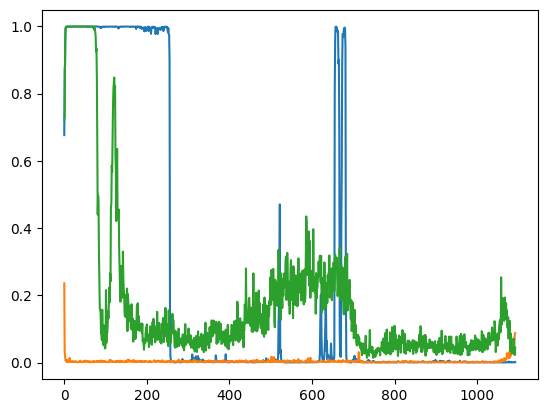

In [55]:
torch.manual_seed(0)
np.random.seed(0)

model = Aversion111Prior_three_party(model_location, whisper_location)
# for speaker 0 
aversion_probabilities_0, X_0 = model.predict(temp_folder, input_folder, input_file, 0, in_dataset=False)
aversion_probabilities_1, X_1 = model.predict(temp_folder, input_folder, input_file, 1, in_dataset=False)
aversion_probabilities_2, X_2 = model.predict(temp_folder, input_folder, input_file, 2, in_dataset=False)
ts = np.arange(0, aversion_probabilities_0.shape[0]) / fps
plt.plot(aversion_probabilities_0[:, 0])
plt.plot(aversion_probabilities_1[:, 0])
plt.plot(aversion_probabilities_2[:, 0])

# since the model doesn't give prediction until later in the audio. 
# I will omit the prediction until the mode is fairly certain
aversion_probability_0 = runEuro(ts, aversion_probabilities_0)[:, 0]
for i in range(0, aversion_probability_0.shape[0]):
    if np.abs(aversion_probability_0[i] - 0.5) <= 0.3:
        aversion_probability_0[i] = 0
    else:
        break

aversion_probability_1 = runEuro(ts, aversion_probabilities_1)[:, 0]
for i in range(0, aversion_probability_1.shape[0]):
    if np.abs(aversion_probability_1[i] - 0.5) <= 0.3:
        aversion_probability_1[i] = 0
    else:
        break

aversion_probability_2 = runEuro(ts, aversion_probabilities_2)[:, 0]
# since the model doesn't give prediction until later in the audio. 
# I will omit the prediction until the mode is fairly certain
for i in range(0, aversion_probability_2.shape[0]):
    if np.abs(aversion_probability_2[i] - 0.5) <= 0.3:
        aversion_probability_2[i] = 0
    else:
        break
    

# convert each signal into binary, 1 is direct gaze, 0 is aversion, here I want aversion probability
aversion_probability_0 = np.where(aversion_probability_0 > 0.5, 1, 0)
aversion_probability_1 = np.where(aversion_probability_1 > 0.5, 1, 0)
aversion_probability_2 = np.where(aversion_probability_2 > 0.5, 1, 0)


In [66]:
import whisper_timestamped
whisper_root = "C:/Users/evansamaa/Documents/GitHub/Gaze_project/models"
audio_path_0 = "F:/MASC/JALI_gaze/Animations/jin2019_4/movie.mp3"
config = json.load(open(os.path.join(*[model_location, "config.json"]), "r"))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
torch.set_default_tensor_type(torch.FloatTensor)
model_word = whisper_timestamped.load_model("base.en", download_root=os.path.join(whisper_root, "whisper"))
torch.set_default_tensor_type(torch.FloatTensor)
raw_word_predictions_0 = whisper_timestamped.transcribe(model_word, audio_path_0, beam_size=5, best_of=5, temperature=(0.0, 0.2, 0.4, 0.6, 0.8, 1.0), vad=True)
word_alignment_0 = []
for s in range(0,len(raw_word_predictions_0["segments"])):
    word_alignment_0 = word_alignment_0 + raw_word_predictions_0["segments"][s]["words"]

 27%|██▋       | 1093/4093 [05:52<16:08,  3.10frames/s]


[{'text': 'Is', 'start': 31.63, 'end': 31.95, 'confidence': 0.001}, {'text': 'this', 'start': 31.95, 'end': 32.11, 'confidence': 0.418}, {'text': 'just', 'start': 32.11, 'end': 32.13, 'confidence': 0.019}, {'text': 'necessarily', 'start': 32.13, 'end': 32.43, 'confidence': 0.0}, {'text': 'crazy,', 'start': 32.43, 'end': 33.19, 'confidence': 0.005}, {'text': 'is', 'start': 33.19, 'end': 33.89, 'confidence': 0.189}, {'text': 'this', 'start': 33.89, 'end': 34.05, 'confidence': 0.754}, {'text': 'something', 'start': 34.05, 'end': 34.73, 'confidence': 0.014}, {'text': 'young?', 'start': 34.73, 'end': 36.81, 'confidence': 0.015}, {'text': 'I', 'start': 37.53, 'end': 38.11, 'confidence': 0.037}, {'text': 'think', 'start': 38.11, 'end': 38.19, 'confidence': 0.082}, {'text': 'we', 'start': 38.19, 'end': 38.43, 'confidence': 0.095}, {'text': 'Supposed...', 'start': 38.43, 'end': 40.91, 'confidence': 0.001}]
